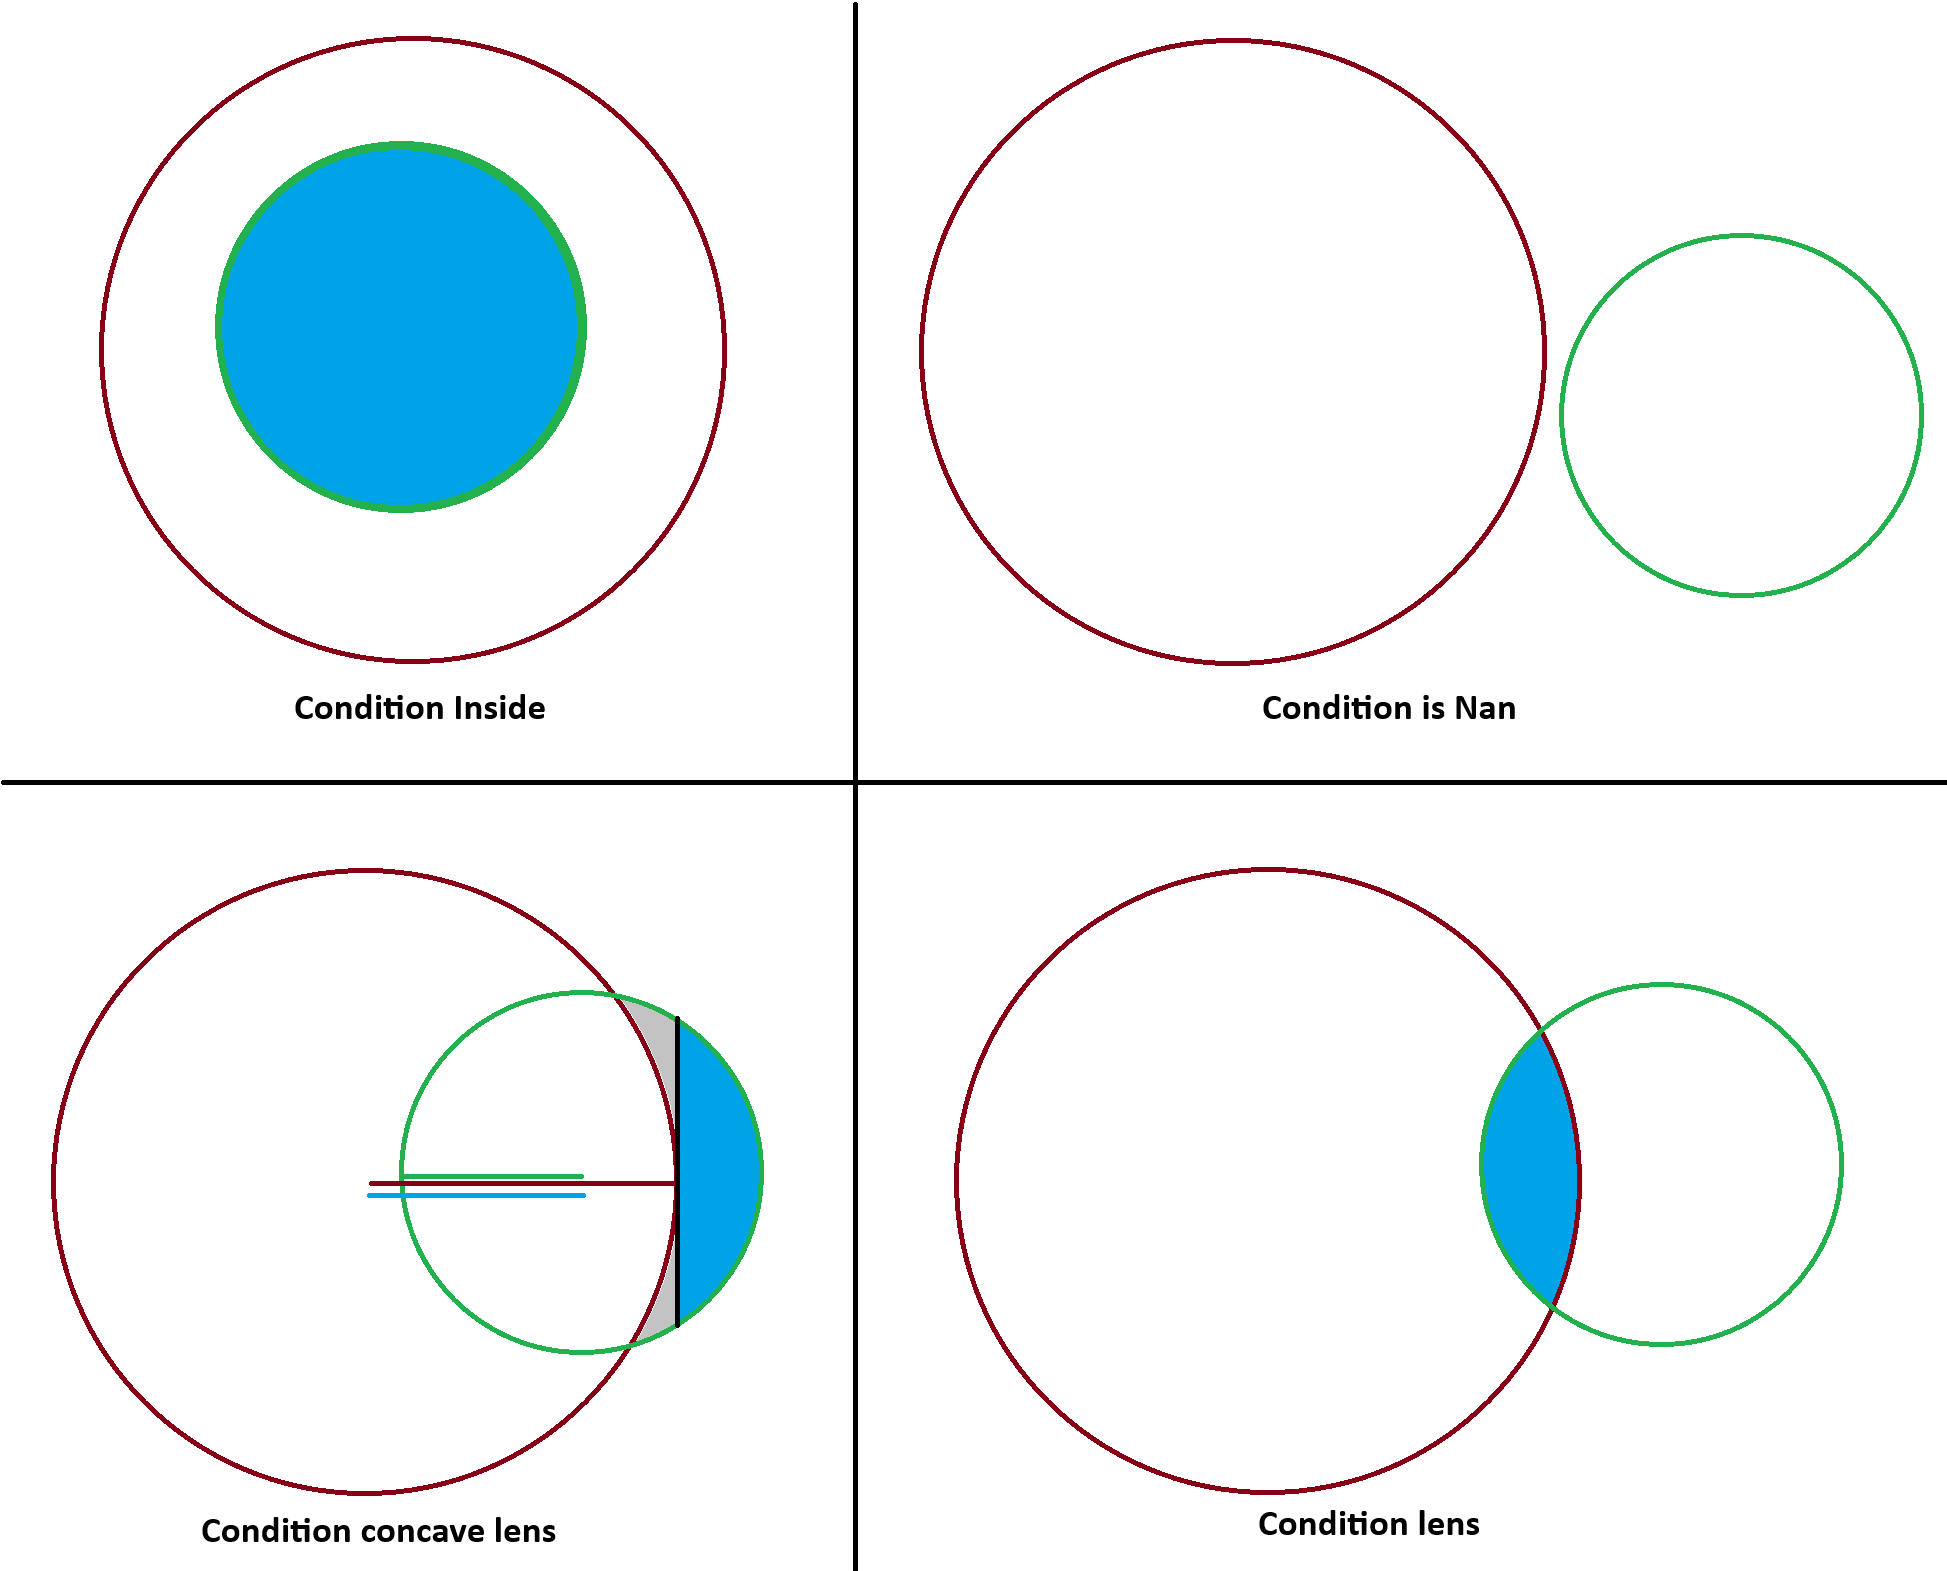

In [ ]:
import torch

def intersection_over_union(predictions, labels):
    """
    Args:
        - predictions (tensor): Tensor containing predicted circles in the format (N, 3), where N is the number of
          predictions and each circle is represented by its center coordinates (x, y) and radius (r).
        - labels (tensor): Tensor containing ground truth circles in the same format as predictions.

    Returns:
        - float: IoU value for all examples in the input tensors.

    This function computes the Intersection over Union (IoU) metric for a set of predicted and ground truth circles
    represented by their center coordinates (x, y) and radius (r). In contrast to the standard YOLO function, where
    IoU is calculated for bounding boxes defined by their width and height, here the IoU is computed for circles.

    """
    circle1_x = predictions[..., 0:1]
    circle1_y = predictions[..., 1:2]
    circle1_r = predictions[..., 2:3]

    circle2_x = labels[..., 0:1]
    circle2_y = labels[..., 1:2]
    circle2_r = labels[..., 2:3]


    # Distance between circle centers
    d = torch.sqrt((circle2_x - circle1_x)**2 + (circle2_y - circle1_y)**2)

    # Max and min for radius and cords
    maxes_r = torch.max(circle1_r, circle2_r)
    mins_r = torch.min(circle1_r, circle2_r)

    #What type of area lenses or concave lenses
    sp = d - maxes_r  #If < 0 then concave lens
    sp = torch.gt(sp, 0)

    # Cheking conditions for tensors
    condition_concave_lens = torch.logical_and(torch.logical_and(torch.logical_and(circle1_r > 0, circle2_r > 0),
                                               torch.logical_and(torch.abs(circle1_r - circle2_r) < d, d < (circle1_r + circle2_r))),
                                                torch.logical_not(sp))
    condition_lens = torch.logical_and(torch.logical_and(torch.logical_and(circle1_r > 0, circle2_r > 0),
                                                         torch.logical_and(torch.abs(circle1_r - circle2_r) < d, d < (circle1_r + circle2_r))),
                                                          sp)
    condition_inside =  torch.logical_and(torch.logical_and((circle1_r > 0),(circle2_r > 0)),
                                          (torch.logical_and((d < circle1_r + circle2_r),(d + mins_r <= maxes_r))))

    # Calculate intersection area for condition
    theta = torch.where(condition_concave_lens, 2*torch.arccos((maxes_r-d)/mins_r), torch.empty_like(d))

    AuB = torch.where(condition_concave_lens,
                       # Circle Area - segment area
                       (torch.pi * mins_r**2) -
                       # segment area = 0.5 * radius**2 * (angle_radians - sin(angle_radians))
                       0.5 * mins_r**2 * (theta - torch.sin(theta))
                       , torch.empty_like(d)) # Default values for non condition

    AuB = torch.where(condition_lens,
                       circle1_r**2 * torch.acos((d**2 + circle1_r**2 - circle2_r**2) / (2 * d * circle1_r)) +
                       circle2_r**2 * torch.acos((d**2 + circle2_r**2 - circle1_r**2) / (2 * d * circle2_r)) -
                       0.5 * torch.sqrt((-d + circle1_r + circle2_r) * (d + circle1_r - circle2_r) * (d - circle1_r + circle2_r) * (d + circle1_r + circle2_r)),
                      AuB)

    AuB = torch.where(condition_inside,
                      (torch.pi * mins_r**2),
                      AuB)

    AuB = torch.where(torch.isnan(AuB), torch.tensor(0), AuB)
    # Calculate output IoU
    A = torch.pi * circle1_r**2
    B = torch.pi * circle2_r**2
    return (AuB / (A + B - AuB ))